In [ ]:

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0399ca2f-b048-fe3e-6f9b-cbdba2586bee)


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 10.86 MiB/s, done.


In [ ]:
ls pubmed-rct/

PubMed_200k_RCT/
PubMed_200k_RCT_numbers_replaced_with_at_sign/
PubMed_20k_RCT/
PubMed_20k_RCT_numbers_replaced_with_at_sign/
README.md


In [ ]:
datadir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
import os
filenames =[datadir + i for i in  os.listdir(datadir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt']

In [ ]:
# reading a text file in
def getlines(filename):
  with open(filename,'r') as f:
    return f.readlines()

In [ ]:
trainlines=getlines("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")

In [ ]:
len(trainlines)

210040

In [ ]:
trainlines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess(filename):
  '''
    [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]

  '''

  input_lines = getlines(filename)
  abstract_lines = ""
  abstract_samples = []
  for line in input_lines:
    if line.startswith("###"):
      abstract_id =line
      abstract_lines = "" #reseting
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data={}
        target_split= abstract_line.split("\t")
        line_data['target']=target_split[0]
        line_data['text']=target_split[1].lower()
        line_data['line_number']=abstract_line_number
        line_data['total_lines']=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples


In [ ]:
train_samples = preprocess("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt")
val_samples = preprocess("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt")
test_samples = preprocess("/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt")


In [ ]:
# dev_samples[:11]

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)



In [ ]:
train_df.shape

(180040, 4)

In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

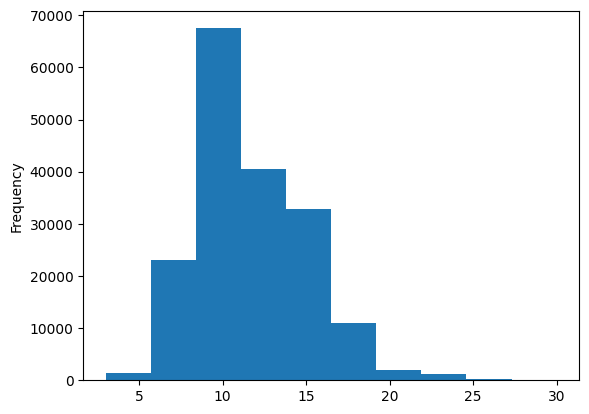

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [ ]:
len(train_sentences)

180040

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder=OneHotEncoder(sparse=False)
train_labels_onehot=onehotencoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_onehot=onehotencoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_onehot=onehotencoder.transform(test_df['target'].to_numpy().reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.preprocessing  import LabelEncoder
labelencoder=LabelEncoder()
train_labelencoder=labelencoder.fit_transform(train_df['target'].to_numpy())
val_labelencoder=labelencoder.transform(val_df['target'].to_numpy())
test_labelencoder=labelencoder.transform(test_df['target'].to_numpy())


In [ ]:
name_of_classes=labelencoder.classes_
no_of_classes=len(labelencoder.classes_)
print(name_of_classes,no_of_classes)

['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS'] 5


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model0=Pipeline(
    [
        ("tfidf",TfidfVectorizer()),
     ('clf',MultinomialNB())
    ]
)
model0.fit(
    X=train_sentences,
    y=train_labelencoder
)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:

model0.score(X=val_sentences,
              y=val_labelencoder)

0.7218323844829869

In [ ]:
pred=model0.predict(test_sentences)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
calculate_results(test_labelencoder,pred)

{'accuracy': 71.6674962667994,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994,
 'f1': 0.6925101703856846}

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent= np.mean(sent_lens)
avg_sent

26.338269273494777

In [ ]:
# output sequence Lenght
import numpy as np

sent_len=[len(i.split()) for i in train_sentences]
np.mean(sent_len)

26.338269273494777

In [ ]:
output_seqlen = int(np.percentile(sent_len, 95))
output_seqlen


55

In [ ]:
max(sent_lens)

296

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vect=TextVectorization(max_tokens=68000,output_sequence_length=output_seqlen)

In [ ]:
text_vect.adapt(train_sentences)

In [ ]:

import random
random_sentences=random.choice(train_sentences)
print(random_sentences.split())
print(len(random_sentences))
print(text_vect([random_sentences]))

['adults', 'aged', '@-@', 'years', 'with', 'mdd', '(', 'dsm-iv-tr', ')', 'and', 'montgomery-asberg', 'depression', 'rating', 'scale', '(', 'madrs', ')', 'total', 'score', '@', 'were', 'randomized', '(', '@:@:@', ')', 'to', 'receive', 'vortioxetine', '@', 'mg', 'or', '@', 'mg', 'or', 'placebo', 'once', 'daily', ',', 'with', 'the', 'primary', 'efficacy', 'end', 'point', 'being', 'change', 'from', 'baseline', 'at', 'week', '@', 'in', 'madrs', 'analyzed', 'by', 'mixed', 'model', 'for', 'repeated', 'measures', '.']
331
tf.Tensor(
[[ 266  307   64    7 2096 7376    3 9641  255  699  158 4112   76  101
     9   29    6  175 6328   68   16   68   16   48  439  161    7    2
    56   79  199  294  571  133   27   49   15   89    5 4112  384   22
   832  314   11  818  213    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)


In [ ]:
vocab=text_vect.get_vocabulary()

In [ ]:
len(vocab)

64841

In [ ]:
token_embedding=tf.keras.layers.Embedding(input_dim=len(vocab),
                                          output_dim=128,
                                          mask_zero=True,
                                          name="Token-Embedding")

In [ ]:
import random
random_sentences=random.choice(train_sentences)
print(random_sentences.split())
print(len(random_sentences))
vector_sent=text_vect([random_sentences])
print(vector_sent)
embedding_vect=token_embedding(vector_sent)
print(embedding_vect)
print(embedding_vect.shape)


['the', 'intervention', 'was', '@', 'one-hour', 'sessions', ',', 'delivered', 'twice', 'a', 'week', 'by', 'teaching', 'assistants', '.']
90
tf.Tensor(
[[    2    38    10 13106   416   785   555     8    89    22  1411  6438
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)
tf.Tensor(
[[[-0.04725617 -0.04933728  0.00376339 ... -0.04211437 -0.04826299
   -0.0034163 ]
  [ 0.04431744 -0.0326433   0.02583479 ...  0.00917558  0.02265865
   -0.04631003]
  [-0.04920825 -0.01312441 -0.01878664 ...  0.04692674  0.00374896
    0.01311085]
  ...
  [-0.02154268 -0.03296816 -0.02405073 ... -0.02818564  0.0430677
   -0.02491224]
  [-0.02154268 -0.03296816 -0.02405073 ... -0.02818564  0.0430677
   -0.02491224]
  [-0.02154268 -0.03296816 -0.02405073 ... -0.02

In [ ]:

train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_onehot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_onehot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_onehot))


In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Input --> tokenize --> Embedding --> layers --> Output

In [ ]:
inputs= tf.keras.layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vect(inputs)
token_embedd=token_embedding(text_vectors)
x=tf.keras.layers.Conv1D(64,kernel_size=5,padding="same",activation='relu')(token_embedd)
x=tf.keras.layers.GlobalAveragePooling1D()(x)
outputs=tf.keras.layers.Dense(no_of_classes,activation='softmax')(x)
model1=tf.keras.Model(inputs,outputs)

model1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)


model1_hist=model1.fit(

    train_dataset,
    steps_per_epoch=int(len(train_dataset)*0.1),
    epochs=3,
    validation_data=val_dataset,
    validation_steps=int(0.1 * len(val_dataset))
)


Epoch 1/3
562/562 [==============================] - 44s 60ms/step - loss: 0.9160 - accuracy: 0.6335 - val_loss: 0.6795 - val_accuracy: 0.7417
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6495 - accuracy: 0.7606 - val_loss: 0.6237 - val_accuracy: 0.7716
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6139 - accuracy: 0.7754 - val_loss: 0.5955 - val_accuracy: 0.7879


In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 Token-Embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
model1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5962 - accuracy: 0.7862


[0.5961905717849731, 0.7862107753753662]

In [ ]:
model1_pred= model1.predict(val_dataset)
model1_pred = tf.argmax(model1_pred, axis=1)

945/945 [==============================] - 2s 2ms/step


In [ ]:
calculate_results(y_true=val_labelencoder,
                  y_pred=model1_pred)

{'accuracy': 78.62107771746327,
 'precision': 0.7829175887437446,
 'recall': 0.7862107771746326,
 'f1': 0.7838077228985812}

Model 2 using token embeddings

Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output

In [ ]:
import tensorflow_hub as hub


tf_hub_embedd= hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    name="Universal_sentemce_encoder"

)

In [ ]:
import random
random_sentences=random.choice(train_sentences)
random_sentences

'xfc could improve btla expression in the peripheral blood of as patients , negatively regulate activation and proliferation of b cells , and reduce abnormal immune responses and oxidative stress injury , thereby effectively alleviating joint stiffness and pain .'

In [ ]:

new=tf_hub_embedd([random_sentences])

In [ ]:
len(new[0])

512

In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedd(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)

outputs = layers.Dense(5, activation="softmax")(x)
model2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

model2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 Universal_sentemce_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 14ms/step - loss: 0.9165 - accuracy: 0.6482 - val_loss: 0.7961 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7683 - accuracy: 0.7023 - val_loss: 0.7542 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 0.7513 - accuracy: 0.7126 - val_loss: 0.7369 - val_accuracy: 0.7158


In [ ]:
model2.evaluate(val_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7387 - accuracy: 0.7148


[0.7387190461158752, 0.7148483991622925]

In [ ]:
model2pred= model2.predict(val_dataset)
model2pred=tf.argmax(model2pred, axis=1)

945/945 [==============================] - 10s 10ms/step


In [ ]:
model2pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model2_result= calculate_results(val_labelencoder,model2pred)

In [ ]:
model2_result

{'accuracy': 71.48484046074407,
 'precision': 0.714645279807203,
 'recall': 0.7148484046074407,
 'f1': 0.7118175742740818}

Model 3 Using Character embedding




In [ ]:
def split_chars(text):
  return " ".join(list(text))
# split_chars(random_sentences)

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]



In [ ]:
len(train_chars)


180040

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation

Num_char_tokens = len(alphabet) + 2 # num characters in alphabet + space + OOV token

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
char_vectorizer = TextVectorization(
    max_tokens=Num_char_tokens,
    standardize="lower_and_strip_punctuation",
    output_sequence_length=output_seq_char_len,
    name="char_vectorizer"
)
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
random_train_chars = random.choice(train_chars)
exp=char_vectorizer(random_train_chars)
char_embed=tf.keras.layers.Embedding(
    input_dim=Num_char_tokens,
    output_dim=25,
    name="char_embed"
)
print(exp)

char_embed(exp)

tf.Tensor(
[21  5  8 19  4  6 18 10  2 18  8  2  2  9  7 17 15  4 24  2 10 21  2  6
  3  4 12  5  3  4  7  6 10 19  9 17 16  6 11  3  4  7  6 20  2  8  2  9
  2  2  6  4  6  3 13  2  3 20  7 18  8  7 16 14  9 22  2 17  7  8  2  3
  8  2  5  3 15  2  6  3  5  6 10 13  7  8 15  7  6  2  3 13  2  8  5 14
 19  9  4 18  6  4 17  4 11  5  6  3 12 19  4 15 14  8  7 21  2 10 14 16
 12 15  7  6  5  8 19 17 16  6 11  3  4  7  6  2  9 14  2 11  4  5 12 12
 19 14  8  7 15  7  3  4  6 18  3 13  2  8  2 11  7 21  2  8 19  7 17  9
 15  5 12 12  5  4  8 20  5 19 17 16  6 11  3  4  7  6  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0], shape=(290,), dtype=int64)


<tf.Tensor: shape=(290, 25), dtype=float32, numpy=
array([[ 0.00317425,  0.02615745, -0.02452153, ...,  0.02275076,
        -0.04309338,  0.00896447],
       [ 0.00150529,  0.03856652,  0.0229555 , ...,  0.01306708,
        -0.04245383,  0.04733391],
       [ 0.02907011,  0.04572539, -0.01938012, ...,  0.00757128,
        -0.00970837,  0.03342677],
       ...,
       [-0.0358265 , -0.01415019,  0.00676708, ..., -0.0334249 ,
         0.04819149,  0.00300946],
       [-0.0358265 , -0.01415019,  0.00676708, ..., -0.0334249 ,
         0.04819149,  0.00300946],
       [-0.0358265 , -0.01415019,  0.00676708, ..., -0.0334249 ,
         0.04819149,  0.00300946]], dtype=float32)>

In [ ]:
input= layers.Input(shape=(1,), dtype="string")
char_vectors=char_vectorizer(input)
embed_vectors=char_embed(char_vectors)
x=layers.Conv1D(64, kernel_size=5,padding="same", activation="relu")(embed_vectors)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(5, activation="softmax")(x)


model3= tf.keras.Model(
    inputs=input,
    outputs=outputs
)
model3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:

train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_onehot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model3history=model3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1 * len(train_char_dataset)),
    epochs=3,
    validation_data=val_char_dataset,
    validation_steps=int(0.1 * len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2725 - accuracy: 0.4821 - val_loss: 1.0599 - val_accuracy: 0.5775
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 1.0197 - accuracy: 0.5929 - val_loss: 0.9594 - val_accuracy: 0.6154
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9300 - accuracy: 0.6336 - val_loss: 0.8837 - val_accuracy: 0.6456


In [ ]:
model3.evaluate(val_char_dataset)


945/945 [==============================] - 4s 4ms/step - loss: 0.8917 - accuracy: 0.6534


[0.8917450904846191, 0.653415858745575]

In [ ]:
model3.metrics_names

['loss', 'accuracy']

Model 4 Using --->  token embeddings + character embeddings
:

In [ ]:
# token input
token_inputs= layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings=tf_hub_embedd(token_inputs)
token_output= layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs,token_output)

# char input
char_input=layers.Input(shape=[], dtype=tf.string, name="char_input")
char_vector=char_vectorizer(char_input)
char_embedding=char_embed(char_vector)
char_bi_lstm=  layers.Bidirectional(layers.LSTM(25))(char_embedding)
char_model=tf.keras.Model(char_input,char_bi_lstm)


#  Concatenate token and char inputs
token_char_con=layers.Concatenate()([token_model.output,char_model.output])
combined_dropout = layers.Dropout(0.5)(token_char_con)
combine_dense= layers.Dense(200,activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combine_dense)
output_layer = layers.Dense(5, activation="softmax")(final_dropout)


model4= tf.keras.Model(
    inputs=[token_model.input, char_model.input],
    outputs=output_layer,
    name="model_4_token_and_char_embeddings"
)

In [ ]:
model4.summary()


Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 Universal_sentemce_encoder (Ke  (None, 512)         256797824   [

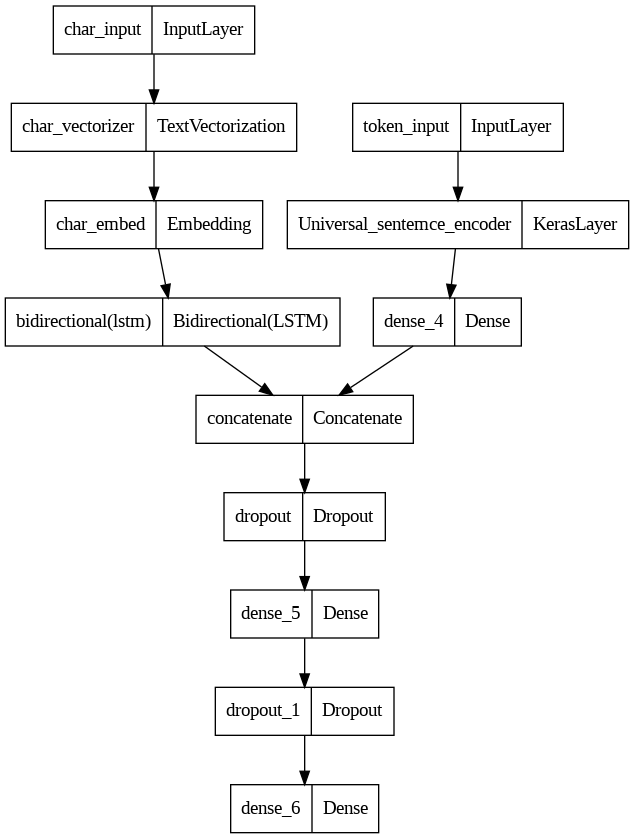

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model4)


In [ ]:
model4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_onehot)
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels=tf.data.Dataset.from_tensor_slices(val_labels_onehot)
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on tokens and chars
model4_history = model4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 38ms/step - loss: 0.9735 - accuracy: 0.6117 - val_loss: 0.7891 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.7982 - accuracy: 0.6903 - val_loss: 0.7228 - val_accuracy: 0.7274
Epoch 3/3
562/562 [==============================] - 20s 35ms/step - loss: 0.7681 - accuracy: 0.7062 - val_loss: 0.7005 - val_accuracy: 0.7360


In [ ]:
model4.evaluate(val_char_token_dataset)


945/945 [==============================] - 19s 20ms/step - loss: 0.7026 - accuracy: 0.7311


[0.7026389241218567, 0.7310671210289001]

In [ ]:
model_4_pred_probs = model4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 19s 19ms/step


array([[4.1306499e-01, 3.8577893e-01, 1.6132997e-03, 1.9502167e-01,
        4.5210440e-03],
       [3.5004148e-01, 4.8237997e-01, 1.1533347e-03, 1.6476060e-01,
        1.6646171e-03],
       [3.1625825e-01, 1.6520411e-01, 3.5550900e-02, 4.5081142e-01,
        3.2175373e-02],
       ...,
       [4.3388506e-04, 5.8832318e-03, 4.6337493e-02, 2.1298813e-04,
        9.4713241e-01],
       [4.4438285e-03, 4.3909367e-02, 2.1001233e-01, 2.6131368e-03,
        7.3902130e-01],
       [2.7919042e-01, 4.6241909e-01, 1.6415957e-01, 4.5959007e-02,
        4.8271939e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true=val_labelencoder,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.10671256454388,
 'precision': 0.7326181865892851,
 'recall': 0.7310671256454389,
 'f1': 0.7288136964672102}

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

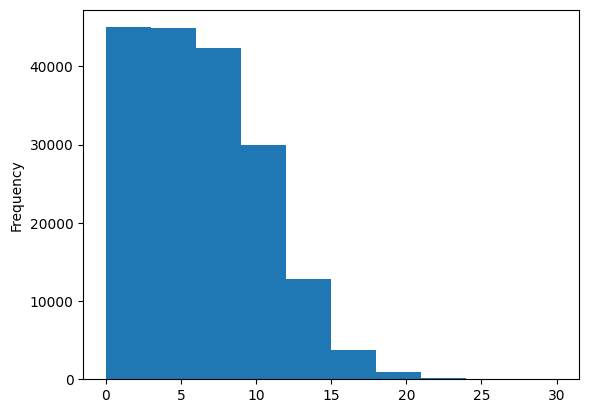

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
train_line_numbers_one_hot= tf.one_hot(train_df["line_number"],depth=15)

In [ ]:
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
train_line_numbers_one_hot= tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot= tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot= tf.one_hot(test_df["line_number"].to_numpy(),depth=15)



Model 5 ----> token embeddings + character embeddings + positional embedding


In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

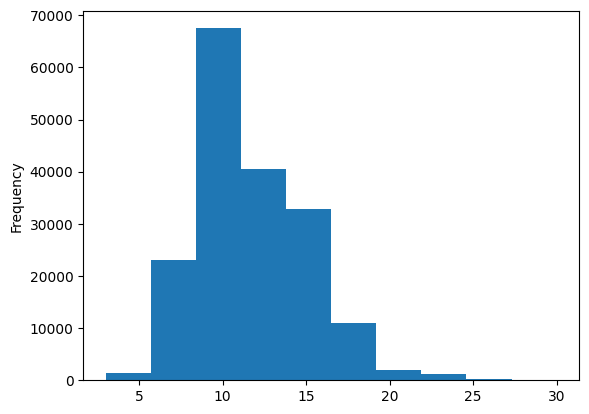

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape

TensorShape([180040, 20])

In [ ]:
# token input
token_inputs= layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings=tf_hub_embedd(token_inputs)
token_output= layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs,token_output)

# char input
char_input=layers.Input(shape=[], dtype=tf.string, name="char_input")
char_vector=char_vectorizer(char_input)
char_embedding=char_embed(char_vector)
char_bi_lstm=  layers.Bidirectional(layers.LSTM(25))(char_embedding)
char_model=tf.keras.Model(char_input,char_bi_lstm)


# 3. line Number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# hybrid embedding

combined_embedding= tf.keras.layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,char_model.output])


z = layers.Dense(256, activation="relu")(combined_embedding)
z = layers.Dropout(0.5)(z)
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])



output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)


model5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)


In [ ]:
model5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 Universal_sentemce_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']      

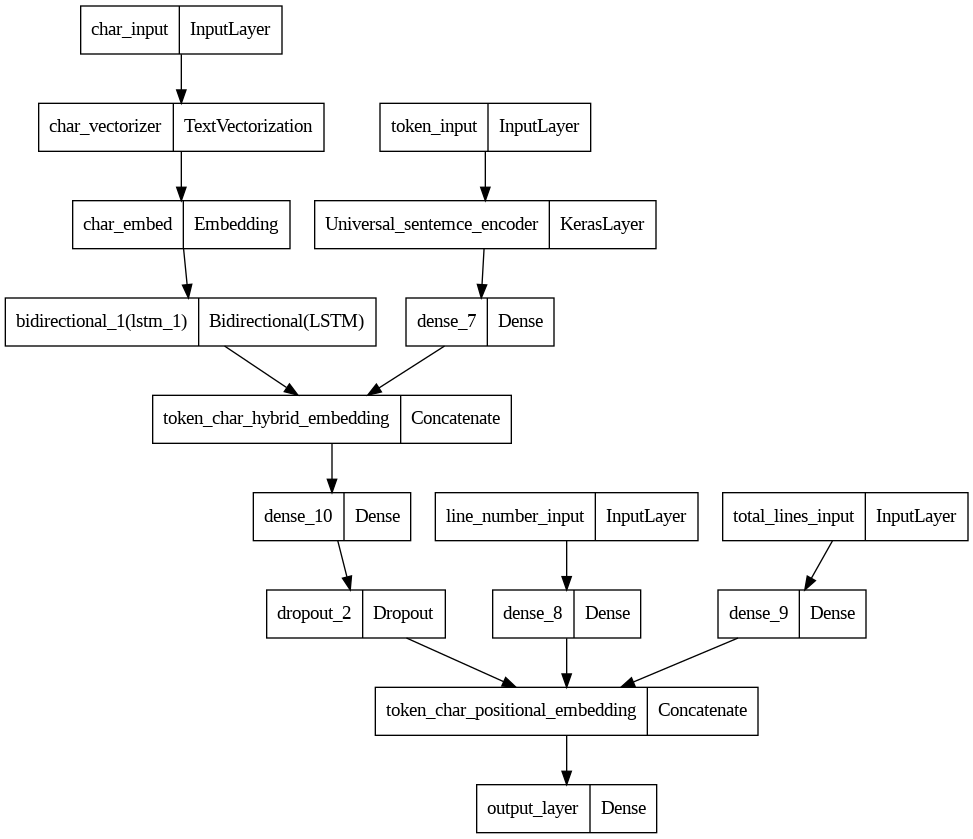

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model5)

In [ ]:
model5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

Label Smoothing:

if our model gets to confident on a single class (e.g. its prediction probability is really high ), it may get stuck on that class and not consider other classes

really confident :`[0.0 , 0.0, 0.0 , 1, 0.0]`

Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:

[0.0, 0.0, 1.0, 0.0, 0.0] for a sample (the model is very confident the right label is index 2).
It's predictions will get smoothed to be something like:

[0.01, 0.01, 0.096, 0.01, 0.01] giving a small activation to each of the other labels, in turn, hopefully improving generalization.


In [ ]:
# training  datasets (all four kinds of inputs)
train_pos_char_token_data= tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,
    train_total_lines_one_hot,
    train_sentences,
    train_chars
))

train_pos_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_onehot)

train_pos_char_token_dataset=tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset=train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_pos_char_token_data= tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_sentences,
    val_chars
))

val_pos_char_token_labels=tf.data.Dataset.from_tensor_slices(val_labels_onehot)

val_pos_char_token_dataset=tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset=val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Fit the token, char and positional embedding model
history_model5 = model5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 29s 39ms/step - loss: 1.0984 - accuracy: 0.7224 - val_loss: 0.9803 - val_accuracy: 0.8059
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9691 - accuracy: 0.8138 - val_loss: 0.9510 - val_accuracy: 0.8268
Epoch 3/3
562/562 [==============================] - 21s 37ms/step - loss: 0.9520 - accuracy: 0.8237 - val_loss: 0.9362 - val_accuracy: 0.8338


In [ ]:
model_5_pred_probs = model5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 20s 20ms/step


array([[0.49168262, 0.1131226 , 0.0117223 , 0.3648925 , 0.01858006],
       [0.551541  , 0.09332425, 0.05519453, 0.2889099 , 0.01103033],
       [0.28762352, 0.11872482, 0.15193644, 0.3601083 , 0.08160694],
       ...,
       [0.03346657, 0.09082864, 0.0366343 , 0.02979078, 0.8092797 ],
       [0.03098967, 0.27089006, 0.08151802, 0.02602679, 0.59057546],
       [0.25084594, 0.5118532 , 0.10778097, 0.04756354, 0.08195627]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labelencoder,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.2152786972064,
 'precision': 0.8308746260343067,
 'recall': 0.8321527869720641,
 'f1': 0.8306573498567587}

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_onehot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

Test data

In [ ]:
result=model5.predict(test_pos_char_token_dataset)

942/942 [==============================] - 19s 20ms/step


In [ ]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2023-07-07 16:16:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2023-07-07 16:16:28 (84.2 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz

In [ ]:
example_abstracts= [{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualized social treatment for high-functioning autism spectrum disorders'},
 {'abstract': "Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D levels with PPD outcomes showed inconsistent associations. Diet: Two Australian RCT's with dietary advice interventions in pregnancy had a positive and null result on PPD. With the exception of fish oil, few RCT's with nutritional interventions during pregnancy assess PPD. Further research is needed to determine whether nutritional intervention strategies during pregnancy can protect against symptoms of PPD. Given the prevalence of PPD and ease of administering PPD measures, we recommend future prenatal nutritional RCT's include PPD as an outcome.",
  'source': 'https://pubmed.ncbi.nlm.nih.gov/28012571/',
  'details': 'Formatting removed (can be used to compare model to actual example)'},
 {'abstract': 'Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden. Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders. There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness. This review provides an overview of the nutritional psychiatry field. It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research. Potential biological pathways related to mental disorders include inflammation, oxidative stress, the gut microbiome, epigenetic modifications and neuroplasticity. Consistent epidemiological evidence, particularly for depression, suggests an association between measures of diet quality and mental health, across multiple populations and age groups; these do not appear to be explained by other demographic, lifestyle factors or reverse causality. Our recently published intervention trial provides preliminary clinical evidence that dietary interventions in clinically diagnosed populations are feasible and can provide significant clinical benefit. Furthermore, nutraceuticals including n-3 fatty acids, folate, S-adenosylmethionine, N-acetyl cysteine and probiotics, among others, are promising avenues for future research. Continued research is now required to investigate the efficacy of intervention studies in large cohorts and within clinically relevant populations, particularly in patients with schizophrenia, bipolar and anxiety disorders.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/28942748/',
  'details': 'Effect of nutrition on mental health'},
 {'abstract': "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients.",
  'source': 'https://pubmed.ncbi.nlm.nih.gov/22244707/',
  'details': 'Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection'}]

In [ ]:
import pandas as pd
abstracts = pd.DataFrame(example_abstracts)
abstracts


,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [ ]:
from spacy.lang.en import English
nlp = English()
sentencizer = nlp.add_pipe("sentencizer")
doc = nlp(example_abstracts[0]["abstract"])
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
total_lines_in_sample = len(abstract_lines)


sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines


[{'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'line_number': 0,
  'total_lines': 7},
 {'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'line_number': 1,
  'total_lines': 7},
 {'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'line_number': 2,
  'total_lines': 7},
 {'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'line_number': 3,
  'total_lines': 7},
 {'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'line_number': 4,
  'total_lines': 7},
 {'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'line_number': 5,
  'total_lines': 7},
 {'text'

In [ ]:
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [ ]:
test_abstract_line_numbers= [line["line_number"] for line in  sample_lines ]

In [ ]:
import tensorflow as tf
test_abstract_lines_onehot=tf.one_hot(test_abstract_line_numbers,15)

In [ ]:
test_abstract_lines_onehot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [ ]:
abstract_chars = [split_chars(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [ ]:
test_abstract_pred_probs = model5.predict(x=(test_abstract_lines_onehot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines),
                                                   tf.constant(abstract_chars)))
test_abstract_pred_probs

1/1 [==============================] - 1s 1s/step


array([[0.31246892, 0.12420028, 0.0161832 , 0.5221132 , 0.02503438],
       [0.08247326, 0.0211854 , 0.7269218 , 0.10588485, 0.06353465],
       [0.14343645, 0.04370969, 0.537173  , 0.16378173, 0.11189922],
       [0.1008774 , 0.15035494, 0.5513628 , 0.07798031, 0.11942456],
       [0.05061734, 0.09207785, 0.46842885, 0.04624268, 0.3426333 ],
       [0.04117822, 0.11612083, 0.58562154, 0.04712569, 0.2099537 ],
       [0.03214103, 0.15119824, 0.12187289, 0.03072358, 0.6640642 ],
       [0.02171924, 0.12181471, 0.32484078, 0.03840406, 0.49322122]],
      dtype=float32)

In [ ]:
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [ ]:
test_abstract_pred_classes = [labelencoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS']

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
METHODS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
METHODS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.
